# Introduction

Use Deep Learning and fruit dataset to predict kind of fruit as the given
image.

https://www.kaggle.com/moltean/fruits

# Data exploration

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
###################

# Declare Test and Training paths
test_dir = '/content/drive/MyDrive/Fruit-Images-Dataset/Training'
train_dir = '/content/drive/MyDrive/Fruit-Images-Dataset/Test'

###################

Load and display the images

(1585, 100, 100, 3)
(1585,)


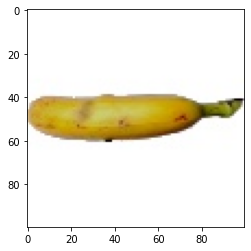

In [ ]:
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

def read_and_process_img(image_path, img_color, img_size):
    '''Read and process a single image from a path'''
    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    # convert the color
    if(img_color == "RGB"):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    elif(img_color == "Gray"):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # resize the image
    imResize = cv2.resize(image, dsize=img_size) 
    return imResize.astype("float32")/255

def read_data(path,img_color,img_size):
    '''Read and process images from a path'''

    data_fruit_img = []
    data_label = []
    for dir_path in glob.glob(path+"/*"):
        img_label = dir_path.split("/")[-1]
        for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
            image = read_and_process_img(image_path,img_color,img_size)
            data_fruit_img.append(image)
            data_label.append(img_label)
    return (np.array(data_fruit_img),np.array(data_label))

X_train,train_label = read_data(train_dir,"RGB",(100,100))
print(X_train.shape)
print(train_label.shape)
plt.imshow(X_train[0])
plt.show()

There are 3395 images. I reduced the number of the images because of the processing time.

The images are 2D with 3 color data
Then we show the 100-image grid

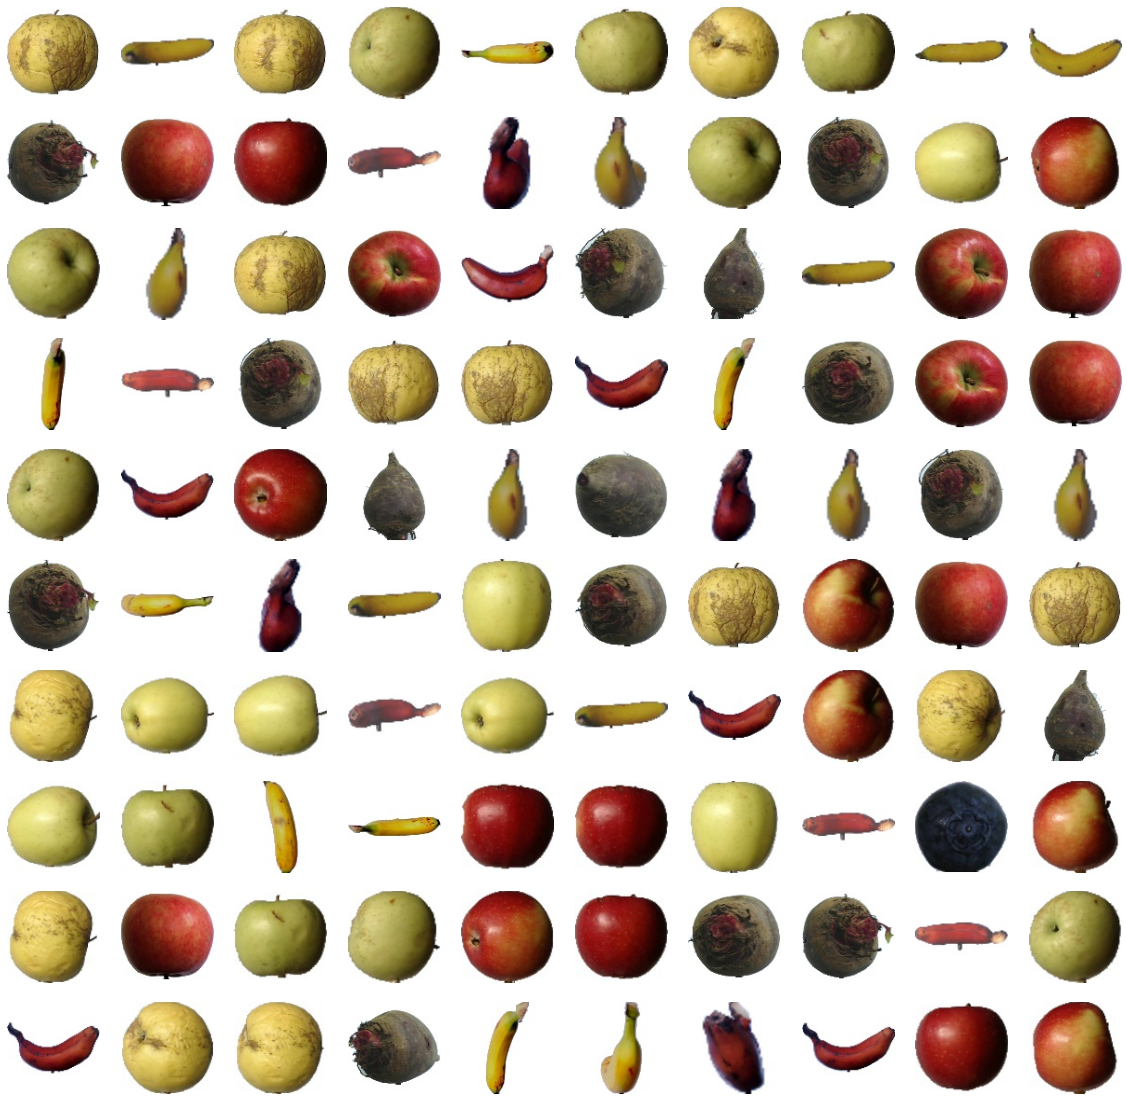

In [ ]:
import random

def plot_image_grid(images, nb_rows, nb_cols, figsize=(20, 20)):
    '''Visualized Array of Images in a grid like plot, given its #of colomns and rows and Figure sizes.'''

    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1

random_sample = random.sample(list(X_train),  100)
plot_image_grid(random_sample, 10, 10)

Visualize the number of images in each image class

Found 1585 images belonging to 10 classes.


<BarContainer object of 10 artists>

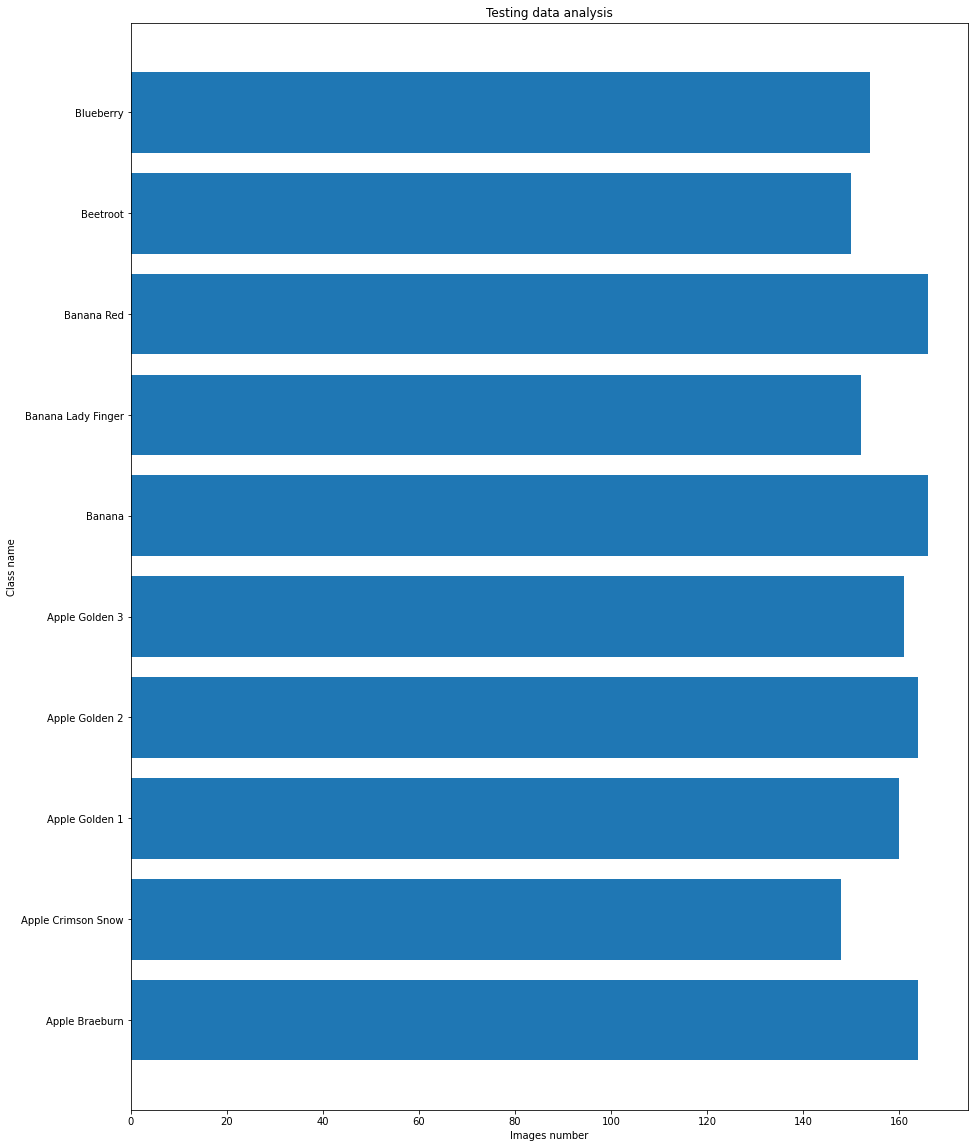

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = data_gen.flow_from_directory(directory=train_dir, target_size=(100, 100), color_mode="rgb",  class_mode='categorical', batch_size=64)

# create data frame
training_data = pd.DataFrame(train_generator.classes, columns=['classes'])

# display plot for image classes
def create_stack_bar_data(col, df):
    '''return index of the class along with number of images in that class'''

    aggregated = df[col].value_counts().sort_index()
    x_values = list(train_generator.class_indices.keys())
    y_values = aggregated.values.tolist()
    return x_values, y_values

x1, y1 = create_stack_bar_data('classes', training_data)

fig, ax = plt.subplots(figsize=(15, 20))
ax.set( xlabel='Images number', ylabel='Class name',
       title='Testing data analysis')
ax.barh(x1, y1)

The number of images for each class is quite equal

# 3. Use CNN to do prediction.

## 3.1 Create and train CNN model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, Lambda

#########

input_shape = (100, 100, 3)
num_classes = 10
learning_rate = 0.1

#########

def convert_to_hsv_and_grayscale(x):
    import tensorflow as tf
    hsv = tf.image.rgb_to_hsv(x)
    gray = tf.image.rgb_to_grayscale(x)
    rez = tf.concat([hsv, gray], axis=-1)
    return rez

img_input = Input(shape=input_shape, name='data')
x = Lambda(convert_to_hsv_and_grayscale)(img_input)
x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(x)
x = Activation('relu', name='conv1_relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
x = Activation('relu', name='conv2_relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
x = Activation('relu', name='conv3_relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
x = Activation('relu', name='conv4_relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
x = Flatten()(x)
x = Dense(1024, activation='relu', name='fcl1')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu', name='fcl2')(x)
x = Dropout(0.2)(x)
out = Dense(num_classes, activation='softmax', name='predictions')(x)
model = Model(inputs=img_input, outputs=out)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            [(None, 100, 100, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 100, 100, 4)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 16)      1616      
_________________________________________________________________
conv1_relu (Activation)      (None, 100, 100, 16)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 50, 50, 32)        12832     
_________________________________________________________________
conv2_relu (Activation)      (None, 50, 50, 32)        0     

Prepare the data and train the model

In [ ]:
##########

image_size = (100, 100)
train_folder = '/content/drive/MyDrive/Fruit-Images-Dataset/Training'
test_folder = '/content/drive/MyDrive/Fruit-Images-Dataset/Test'
model_path = '/content/drive/MyDrive/Fruit-Images-Dataset/model/model.h5'

validation_percent = 0.1              # percentage indicating how much of the training set should be kept for validation
verbose = True                        # enable logging report
learning_rate = 0.1                   # learning rate of the training
learning_rate_reduction_factor = 0.5  # reduce learning rate ro reach minimal loss
min_learning_rate = 0.00001           # minimum learning rate after reduction
patience = 3                          # how many epochs to wait before reducing the learning rate when the loss plateaus
epochs=25                             # total number of epochs
batch_size=50

##########

if use_label_file:
    with open(label_file, "r") as f:
        labels = [x.strip() for x in f.readlines()]
else:
    labels = os.listdir(train_dir)

# Generate data for training, validation and testing
train_datagen = ImageDataGenerator(
    width_shift_range=0.0,
    height_shift_range=0.0,
    zoom_range=0.0,
    horizontal_flip=True,
    vertical_flip=True,  # randomly flip images
    preprocessing_function=None, 
    validation_split=validation_percent)  # percentage indicating how much of the training set should be kept for validation

test_datagen = ImageDataGenerator()

train_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                  batch_size=batch_size, shuffle=True, subset='training', classes=labels)
validation_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                  batch_size=batch_size, shuffle=False, subset='validation', classes=labels)
test_gen = test_datagen.flow_from_directory(test_folder, target_size=image_size, class_mode='sparse',
                                                  batch_size=batch_size, shuffle=False, subset=None, classes=labels)

# Train the model
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

optimizer = Adadelta(lr=learning_rate)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=patience, verbose=verbose, 
                                            factor=learning_rate_reduction_factor, min_lr=min_learning_rate)
save_model = ModelCheckpoint(filepath=model_path, monitor='val_accuracy', verbose=verbose, 
                              save_best_only=True, save_weights_only=False, mode='max')

history = model.fit(train_gen,
                    epochs=epochs,
                    steps_per_epoch=(train_gen.n // batch_size) + 1,
                    validation_data=validation_gen,
                    validation_steps=(validation_gen.n // batch_size) + 1,
                    verbose=verbose,
                    callbacks=[learning_rate_reduction, save_model])

model.load_weights(model_path)

validation_gen.reset() # restart the iterator of the validation data set for evaluation

# Evaluate the model with the validation and testing data set
loss_v, accuracy_v = model.evaluate(validation_gen, steps=(validation_gen.n // batch_size) + 1, verbose=verbose)
loss, accuracy = model.evaluate(test_gen, steps=(test_gen.n // batch_size) + 1, verbose=verbose)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss_v = %f" % (accuracy, loss))

Found 4259 images belonging to 10 classes.
Found 472 images belonging to 10 classes.
Found 1585 images belonging to 10 classes.
Epoch 1/25
86/86 [==============================] - 1051s 12s/step - loss: 6.4264 - accuracy: 0.3715 - val_loss: 0.7670 - val_accuracy: 0.6525

Epoch 00001: val_accuracy improved from -inf to 0.65254, saving model to /content/drive/MyDrive/Fruit-Images-Dataset/model/model.h5
Epoch 2/25
86/86 [==============================] - 112s 1s/step - loss: 0.6724 - accuracy: 0.7711 - val_loss: 0.1355 - val_accuracy: 0.9619

Epoch 00002: val_accuracy improved from 0.65254 to 0.96186, saving model to /content/drive/MyDrive/Fruit-Images-Dataset/model/model.h5
Epoch 3/25
86/86 [==============================] - 111s 1s/step - loss: 0.3185 - accuracy: 0.8825 - val_loss: 0.0491 - val_accuracy: 0.9852

Epoch 00003: val_accuracy improved from 0.96186 to 0.98517, saving model to /content/drive/MyDrive/Fruit-Images-Dataset/model/model.h5
Epoch 4/25
86/86 [========================

With the validation data on the CNN model, the results is 100% accuracy of prediction.

With the testing data, the result is 95% accuracy of prediction

In [ ]:
# plot history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
# plot history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Test the model with individual images

### Report the result with classification_report

In [ ]:
test_gen.reset()
y_pred = model.predict(test_gen, steps=(test_gen.n // batch_size) + 1, verbose=verbose)
y_true = test_gen.classes[test_gen.index_array]
plot_confusion_matrix(y_true, y_pred.argmax(axis=-1), labels, out_path=model_out_dir)
class_report = classification_report(y_true, y_pred.argmax(axis=-1), target_names=labels)